In [ ]:
import os
import urllib
import numpy as np
import skimage
import tensorflow as tf
os.chdir("..")
from parc import model, metrics, visualization, misc

## PARC prediction at unseen time steps

PARC was trained with 19 time steps. In this demo, we show the predictive capability of PARC at the unseen time step. 
The extension prediction procedure is as follow:
- Initiate the PARC model with extended number of time step (36 in this case)
- Load the pretrained weight
- Perform the prediction and compare results with DNS

### Load data for prediction

In [3]:
url_data_in = 'https://virginia.box.com/shared/static/see7wprmzcblnogi9rkrsjlq2k0bk0zf.npy'
print( 'get data_in longer timestep prediction:', end='\t')
response = urllib.request.urlretrieve(url_data_in, 'data_in_test_long.npy')
print( 'complete' )
url_data_out = 'https://virginia.box.com/shared/static/cst158uoqth39jy15biglix76so7pfq3.npy'
print( 'get data_out longer timestep prediction:', end='\t')
response = urllib.request.urlretrieve(url_data_out, 'data_out_test_long.npy')
print( 'complete' )

url_model = 'https://virginia.box.com/shared/static/cfhjl1a3r8n2ymatpjqwc70y96d42e0q.h5'
print( 'get pre-trained model:', end='\t')
response = urllib.request.urlretrieve(url_model, 'preTrain.h5')
print( 'complete' )


# Temperature and pressure field snapshots 
data_out = np.load("data_out_test_long.npy") 
# Microstructure data
data_in = np.load("data_in_test_long.npy")

## split data
X_long = data_in[:,:,:,:]
y_long = data_out[:,:,:,2:]
X_long_init = data_out[:,:,:,0:2]

get data_in longer timestep prediction:	complete
get data_out longer timestep prediction:	complete
get pre-trained model:	complete


### Load prediction model for longer time step

In [4]:
parc_extend = model.PARC(input_size=240, n_fields=2, n_timesteps=36)
parc_extend.build()
# parc.summary()
parc_extend.load_weights("preTrain.h5")

### Make prediction

In [5]:
# Perform prediction on test set
parc_pred = parc_extend.predict([X_long,X_long_init])

1/1 [==============================] - 13s 13s/step


## Plot temperature field evolution

In [ ]:
visualization.plot_field_evolution_extendedTS( y_true=y_long, y_pred=parc_pred, case_idx = 2, temp_range=(300,4000) )

## Plot sensitivity 

### Compute sensitivity metrics for extended simulation

In [7]:
Temp_pred_parc = parc_pred[0][:,:,:,0::2]
Temp_gt = y_long[:,:,:,0::2]

Temp_pred_parc = misc.scale_temperature(Temp_pred_parc, start_ts = 3, max_temp = 4000, min_temp = 300)
Temp_gt = misc.scale_temperature(Temp_gt, start_ts = 3, max_temp = 4000, min_temp = 300)


# Compute sensitivity of ground truth data
gt_hs_temp_extra, gt_hs_area_extra = visualization.calculate_hotspot_tempNarea(Temp_gt, cases_range = (0,1), n_timesteps = 33)
gt_rate_hs_temp_extra,gt_rate_hs_area_extra = visualization.calculate_hotspot_tempNarea_rateOfChange(Temp_gt, cases_range = (0,1), n_timesteps = 33)

# Compute sensitivity of PARC prediction
parc_hs_temp_extra, parc_hs_area_extra = visualization.calculate_hotspot_tempNarea(Temp_pred_parc, cases_range = (0,1), n_timesteps = 33)
parc_rate_hs_temp_extra, parc_rate_hs_area_extra = visualization.calculate_hotspot_tempNarea_rateOfChange(Temp_pred_parc, cases_range = (0,1), n_timesteps = 33)

### Plot sensitivity evolution

In [9]:
import matplotlib.pyplot as plt

def sensitivity_plot(gt_data, parc_data, metric):
    # Initiate figure
    plt.figure (figsize= (13,10))

    # Check type of metric to generate proper setting
    if metric == "hs_temp" or metric == "hs_area":
        # Create discrete time steps
        ts = np.linspace(3.16,28.44,33)

    elif metric == "rate_hs_temp" or metric == "rate_hs_area":
        # Create discrete time steps
        ts = np.linspace(3.16,27.65,32)
    else:
        print("Wrong metric selection. Possible metrics are: 'hs_temp', 'hs_area', 'rate_hs_temp', 'rate_hs_area")

    # Main plot 
    # Plot mean value
    plt.plot(ts,gt_data[0], color='#023FA3',lw=2.5,label='Ground truth')
    plt.plot(ts,parc_data[0], color='#D91820',lw=2.5,label='Prediction')
    plt.plot([15.01, 15.01], [-30, 5000], 'k-', lw=2, ls = '--') # Denote the length of training simulation\a
    
    # Title and axe settings
    # Check type of metric to generate proper setting
    if metric == "hs_temp":
        # Create discrete time steps
        # Plot title
        plt.title(r'Ave. Hotspot Temperature ($T_{hs}$)', fontsize = 32, pad = 15)
        plt.xlabel(r"t ($ns$)", fontsize = 28)
        plt.ylabel(r' $T_{hs}$ ($K$)', fontsize = 28)
        plt.axis([3.16, 28, 0, 5000])
        text_pos = (9.2, 1000, 20.2, 1000)

    elif metric == "hs_area":
        plt.title(r'Hotspot Area ($A_{hs}$)', fontsize = 32, pad = 15)
        plt.xlabel(r"t ($ns$)", fontsize = 28)
        plt.ylabel(r'$A_{hs}$ ($\mu m^2$)', fontsize = 28)
        plt.axis([3.16,28, 0, 800])
        text_pos = (9.2, 400, 20.2, 150)

    elif metric == "rate_hs_temp":
        plt.title(r'Ave. Hotspot Temperature Rate of Change ($\dot{T_{hs}}$)', fontsize = 32, pad = 15)
        plt.xlabel(r"t ($ns$)", fontsize = 28)
        plt.ylabel(r"$\dot{T_{hs}}$ ($K$/$ns$)", fontsize = 28)
        plt.axis([3.16, 28, -30, 800])
        text_pos = (9.2, 550, 20.2, 400)

    else:
        plt.title(r'Hotspot Area Rate of Change ($\dot{A_{hs}}$)', fontsize = 32,pad = 15)
        plt.xlabel(r"t ($ns$)",fontsize = 28)
        plt.ylabel(r"$\dot{A_{hs}}$ ($\mu m^2$/$ns$)",fontsize = 28)
        plt.axis([3.16, 28, 0, 100])
        text_pos = (9.2, 50, 20.2, 50)

    ax = plt.gca()
    ax.text(
        text_pos[0], text_pos[1], ("Training simulation \n" + "time: 15.01 (ns)"),
        ha="center", va="center", rotation=0, size=24,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec = '#023FA3', lw=2))
    ax.text(
        text_pos[2], text_pos[3], ("Extended simulation \n" + "time"), ha="center", va="center", rotation=0, size=24,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec = '#D91820', lw=2))
    plt.xticks(fontsize= 28)
    plt.yticks(fontsize= 28)
    plt.legend(loc = 2, fontsize = 28)
    plt.show()
    return None

#### Average hotspot temperature

C:\Users\josep\AppData\Local\Temp\ipykernel_29180\1072210199.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([15.01, 15.01], [-30, 5000], 'k-', lw=2, ls = '--') # Denote the length of training simulation\a


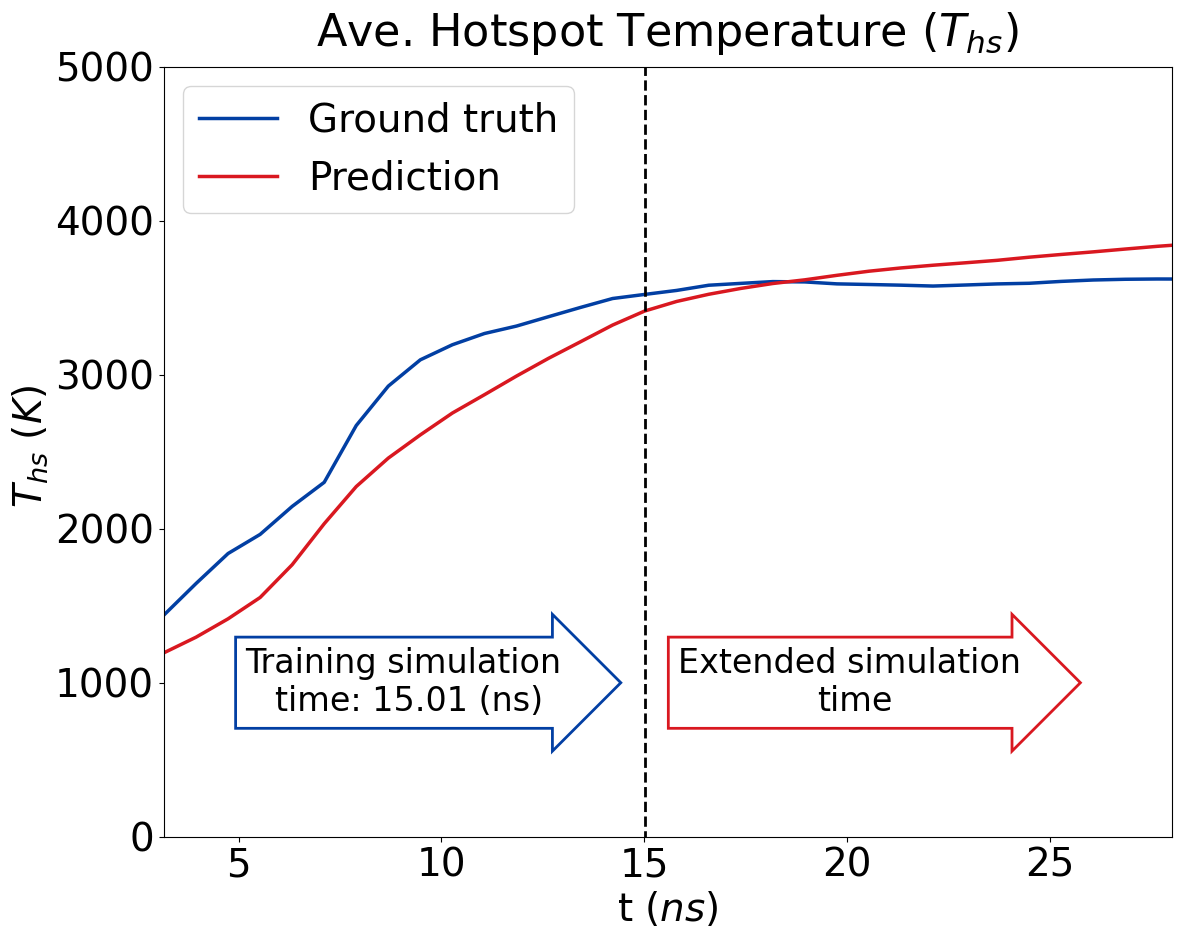

In [10]:
sensitivity_plot(gt_hs_temp_extra, parc_hs_temp_extra, metric = "hs_temp")

#### Total hotspot area

C:\Users\josep\AppData\Local\Temp\ipykernel_29180\1072210199.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([15.01, 15.01], [-30, 5000], 'k-', lw=2, ls = '--') # Denote the length of training simulation\a


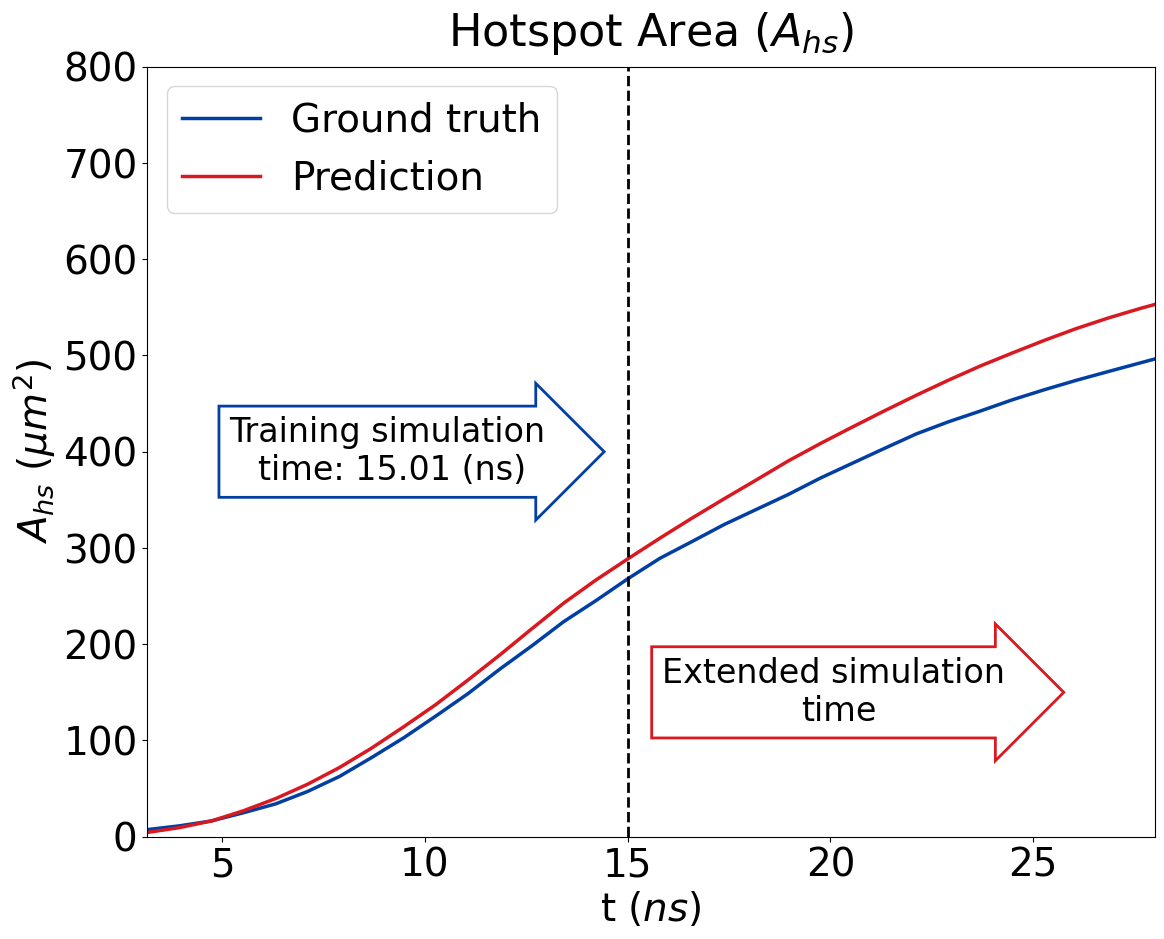

In [11]:
sensitivity_plot(gt_hs_area_extra, parc_hs_area_extra, metric = "hs_area")

#### Average hotspot temperature rate of change

C:\Users\josep\AppData\Local\Temp\ipykernel_29180\1072210199.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([15.01, 15.01], [-30, 5000], 'k-', lw=2, ls = '--') # Denote the length of training simulation\a


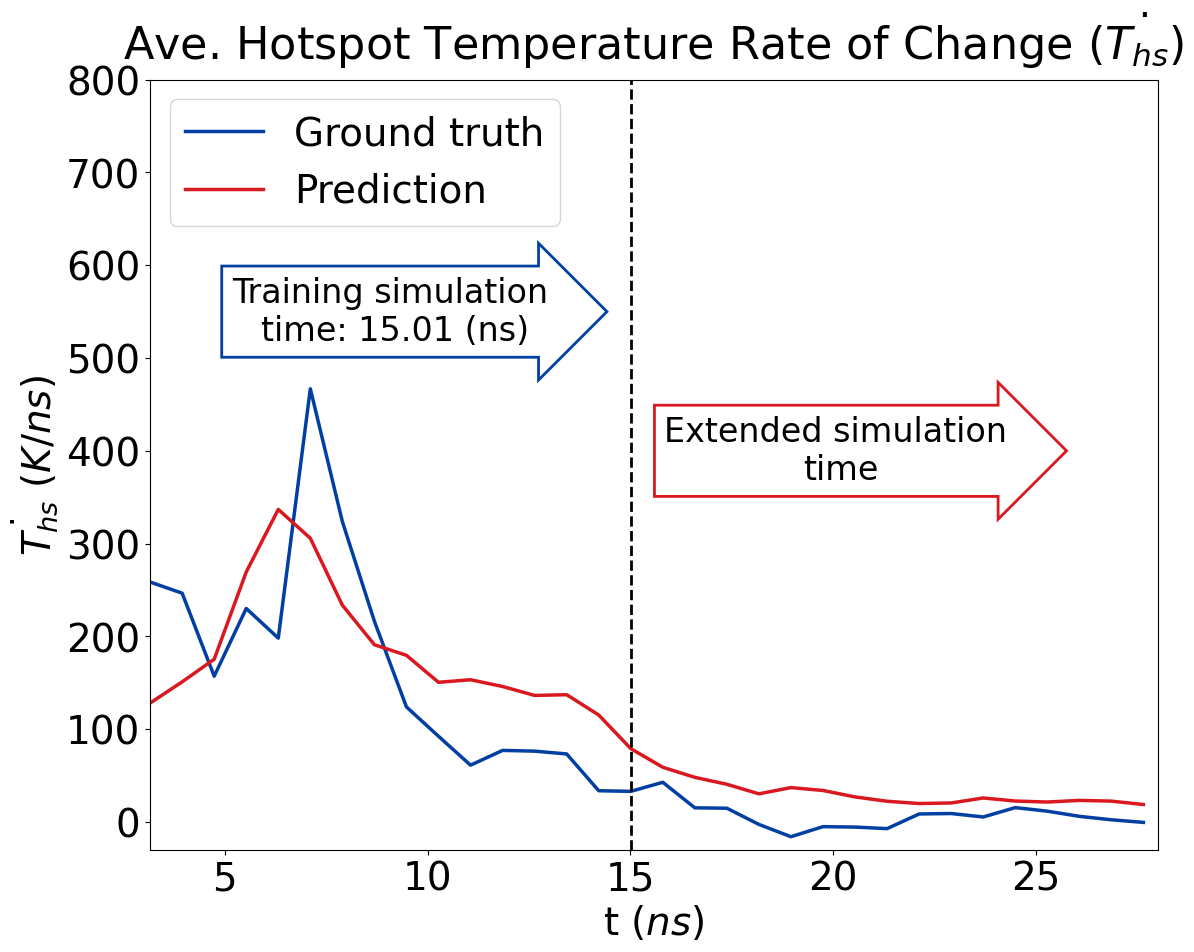

In [12]:
sensitivity_plot(gt_rate_hs_temp_extra, parc_rate_hs_temp_extra, metric = "rate_hs_temp")

#### Total hotspot area rate of change

C:\Users\josep\AppData\Local\Temp\ipykernel_29180\1072210199.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([15.01, 15.01], [-30, 5000], 'k-', lw=2, ls = '--') # Denote the length of training simulation\a


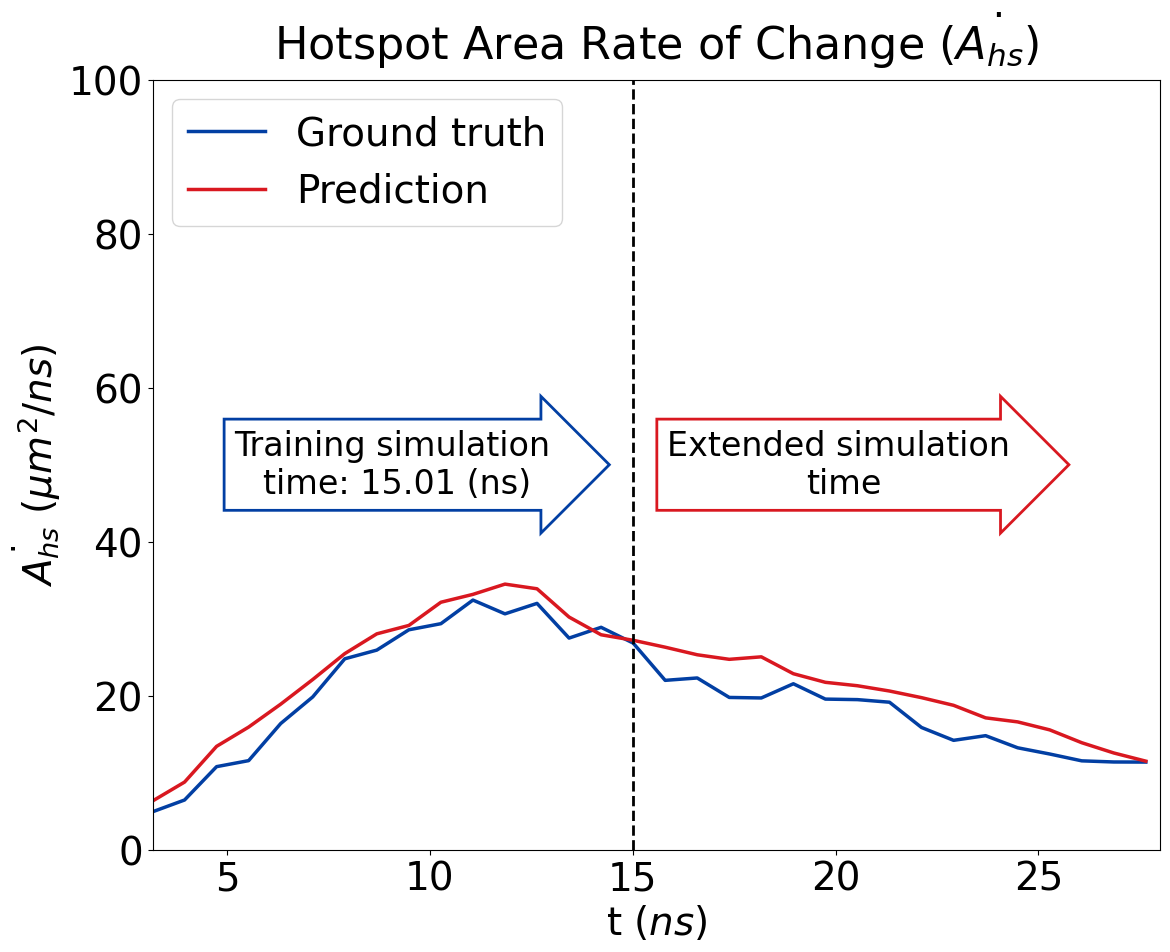

In [13]:
sensitivity_plot(gt_rate_hs_area_extra, parc_rate_hs_area_extra, metric = "rate_hs_area")